### Importacion de librerias 

In [28]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

### Extraer datos

In [16]:
df = pd.read_csv("../data/clean_dataset.csv")
df

,Freedom,Generosity,Perceptions_of_corruption,GDP_per_capita,Healthy_life_expectancy,Happiness_Score,Social_support,Year,Region_Australia_and_New_Zealand,Region_Central_and_Eastern_Europe,Region_Eastern_Asia,Region_Latin_America_and_Caribbean,Region_Middle_East_and_Northern_Africa,Region_North_America,Region_Southeastern_Asia,Region_Southern_Asia,Region_Sub-Saharan_Africa,Region_Western_Europe
0,0.66557,0.29678,0.41978,1.39651,0.94143,7.587,1.34951,2015,0,0,0,0,0,0,0,0,0,1
1,0.62877,0.43630,0.14145,1.30232,0.94784,7.561,1.40223,2015,0,0,0,0,0,0,0,0,0,1
2,0.64938,0.34139,0.48357,1.32548,0.87464,7.527,1.36058,2015,0,0,0,0,0,0,0,0,0,1
3,0.66973,0.34699,0.36503,1.45900,0.88521,7.522,1.33095,2015,0,0,0,0,0,0,0,0,0,1
4,0.63297,0.45811,0.32957,1.32629,0.90563,7.427,1.32261,2015,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,0.55500,0.21700,0.41100,0.35900,0.61400,3.334,0.71100,2019,0,0,0,0,0,0,0,0,1,0
778,0.41700,0.27600,0.14700,0.47600,0.49900,3.231,0.88500,2019,0,0,0,0,0,0,0,0,1,0
779,0.00000,0.15800,0.02500,0.35000,0.36100,3.203,0.51700,2019,0,0,0,0,0,0,0,1,0,0
780,0.22500,0.23500,0.03500,0.02600,0.10500,3.083,0.00000,2019,0,0,0,0,0,0,0,0,1,0


In [17]:
df = df.rename(columns={
    'Region_Sub-Saharan_Africa': 'Region_Sub_Saharan_Africa'
})


### Entrenamiento de los modelos

In [35]:
# Dividir los datos en características (X) y variable objetivo (y)
X = df.drop(columns=['Happiness_Score'])
y = df['Happiness_Score']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50
)

# Definir los modelos de regresión
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=50),
    'Gradient Boosting': GradientBoostingRegressor(random_state=50),
    'Ridge': Ridge(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=50, n_jobs=-1),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=50)
}

# Lista para almacenar los resultados
results = []

# Entrenar y evaluar cada modelo
for name, estimator in models.items():
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    
    results.append({
        'Modelo': name,
        'MSE': round(mean_squared_error(y_test, y_pred), 4),
        'R2 Score': round(r2_score(y_test, y_pred), 4)
    })

# Crear DataFrame con los resultados
results_df = pd.DataFrame(results)

# Ordenar por R2 Score de mayor a menor
results_df = results_df.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)

# Imprimir resultados
print("\nResultados de los Modelos:")
print(results_df.to_string(index=False))


Resultados de los Modelos:
           Modelo    MSE  R2 Score
         CatBoost 0.1344    0.8998
    Random Forest 0.1587    0.8817
          XGBoost 0.1759    0.8688
Gradient Boosting 0.1793    0.8663
            Ridge 0.2256    0.8318
Linear Regression 0.2260    0.8315


### Y_test vs Y_pred

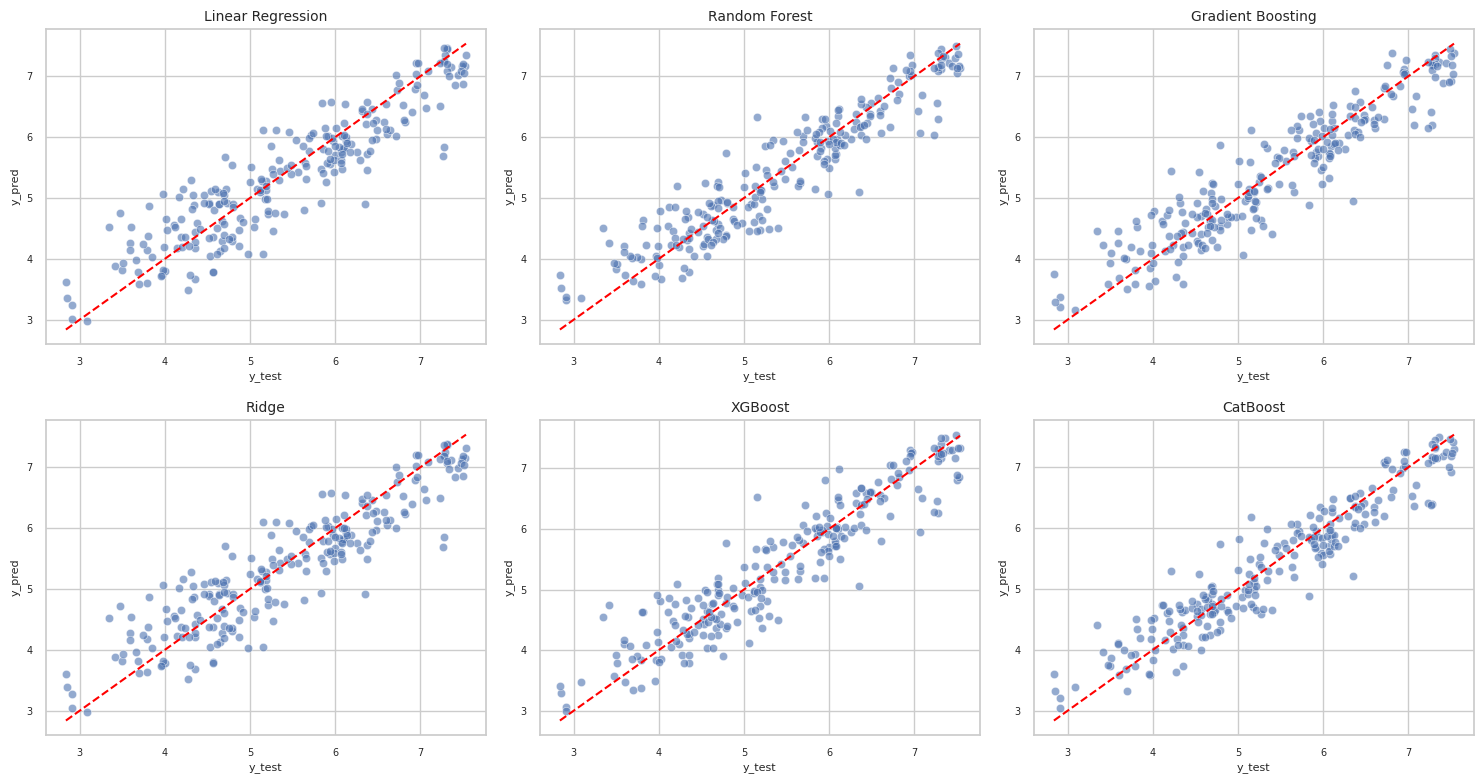

In [26]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()  # Aplanamos para iterar fácilmente

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    ax = axes[i]
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, ax=ax)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    ax.set_title(name, fontsize=10)
    ax.set_xlabel("y_test", fontsize=8)
    ax.set_ylabel("y_pred", fontsize=8)
    ax.tick_params(labelsize=7)

# Si hay más subplots de los que necesitamos, los apagamos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



### Guardar el modelo

In [36]:
# Entrenar CatBoost
cat_model = CatBoostRegressor(verbose=0, random_state=50)
cat_model.fit(X_train, y_train)

# Guardar el modelo
with open('../models/catboost_model.pkl', 'wb') as file:
    pickle.dump(cat_model, file)
